In [389]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Learning Concepts

In this notebook, we experiment with how to learn the function $f(c|...)$ which models a set of inputs to the ouput concept. The dataset used here is generated in the windy gridworld environment. The following conditional relationships will be explored:

* $f(c|s)$
* $f(c|s,a)$
* $f(c|s,a,s')$
* $f(c|s,a,r_{s}$ where $r_s$ is the short term reward
* $f(c|s,a,r_{l})$ where $r_l$ is the longer term reward
* $f(c|s,a,\bar{s})$ where $\bar{s}$ may indicate the k-NN of state s for example
* $f(c|s,a,\theta)$ where $\theta$ is some unknown parameter

A MLP will be used to model these functions in order to learn a mapping from the set of inputs to the concept.


In [390]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("dataset_large.npz")
print(np.array(trajectories, dtype=object).shape)
print(np.array(rewards).shape)
print(np.array(unique_concepts, dtype=object).shape)
print(np.array(concepts, dtype=object).shape)
print(np.array(actions, dtype=object).shape)
print(means.shape)
print(clusters.shape)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(653,)
(653,)
(653,)
(653,)
(653,)
(5, 2)
(500, 2)


## Preprocessing

Apply any preprocessing at this point.

In [404]:
num_concepts = len(means)
up = np.array([0, 1])
down = np.array([0, -1])
right = np.array([1, 0])
left = np.array([-1, 0])

A = np.array([up, down, right, left])


def generate_default_dataset():
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)


def generate_states_actions_dataset():
    '''Adds third element to input vector which is the action taken in the current state'''
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories))
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    actions_indexed = actions_indexed.reshape(len(actions_indexed), 1)
    X = np.concatenate((X, actions_indexed), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)

def generate_states_next_states_dataset():
    ''''''
    windowed_states = window_states(trajectories)
    shifted_trajectories = shift_states(windowed_states)

    Y = np.concatenate(concepts)
    X = np.concatenate(windowed_states)
    X_shifted = np.concatenate(shifted_trajectories)
    X = np.concatenate((X, X_shifted), axis=1)   

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)

def generate_states_next_states_actions_dataset():
    ''''''
    windowed_states = window_states(trajectories)
    shifted_trajectories = shift_states(windowed_states)
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    actions_indexed = actions_indexed.reshape(len(actions_indexed), 1)
    Y = np.concatenate(concepts)
    X = np.concatenate(windowed_states)
    X_shifted = np.concatenate(shifted_trajectories)
    X = np.concatenate((X, X_shifted, actions_indexed), axis=1) 

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)




def window_states(trajectories):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    W_s = 30
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')


def generate_voted_actions(actions_indexed):
    '''Removes some noise from the action policy by setting the action taken to a vote over the previous W_a actions'''
    W_a = 10
    voted_actions = []
    for traj in actions:
        voted_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_a, i):i]
            voted_traj[i-1] = np.sum(window, axis=0)/len(window)
        voted_actions.append(voted_traj)
    return np.array(voted_actions, dtype='object')


def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

def shift_states(trajectories):
    shifted_trajectories=[]
    for traj in trajectories:
        n = len(traj)-1
        shifted = np.zeros(traj.shape)
        shifted[0:n-1] = traj[1:n]
        shifted[n] = shifted[n-1]
        shifted_trajectories.append(shifted)
    return shifted_trajectories



## Define Generic Model

In [392]:
from keras.models import Sequential
from keras.layers import Dense

class ConceptModel():
    def __init__(self, input_size, num_concepts) -> None:
        self.input_size = input_size
        self.output_size = num_concepts
    
    def build(self):
        model = Sequential()
        model.add(Dense(64, activation="relu", input_shape=self.input_size))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_size, activation="softmax"))

        model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


## $f(c|s)$

In [393]:
X_train, X_test, y_train, y_test = generate_default_dataset()
print(X_train.shape)
print(y_train.shape)
model1 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

#try k-NN cluster assignment in trajectory generation as another experiment


(322004, 2)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.1524 - categorical_accuracy: 0.9351 - val_loss: 0.1381 - val_categorical_accuracy: 0.9395
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1400 - categorical_accuracy: 0.9388 - val_loss: 0.1480 - val_categorical_accuracy: 0.9343
Epoch 3/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1388 - categorical_accuracy: 0.9391 - val_loss: 0.1360 - val_categorical_accuracy: 0.9396
Epoch 4/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1381 - categorical_accuracy: 0.9393 - val_loss: 0.1340 - val_categorical_accuracy: 0.9409
Epoch 5/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1369 - categorical_accuracy: 0.9395 - val_loss: 0.1364 - val_categorical_accuracy: 0.9395
Epoch 6/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1364 - categorical_accuracy: 0.9399 - val_loss: 0.1326 - 

In [394]:
score = model1.evaluate(X_test, y_test)
print(model1.metrics_names)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 685us/step - loss: 0.1329 - categorical_accuracy: 0.9423
['loss', 'categorical_accuracy']
Test loss: 0.13286429643630981 
Test accuracy: 0.9423485398292542


In [395]:
X_window = window_states(trajectories)

Number of misclassified concepts: 20
Reward: -579


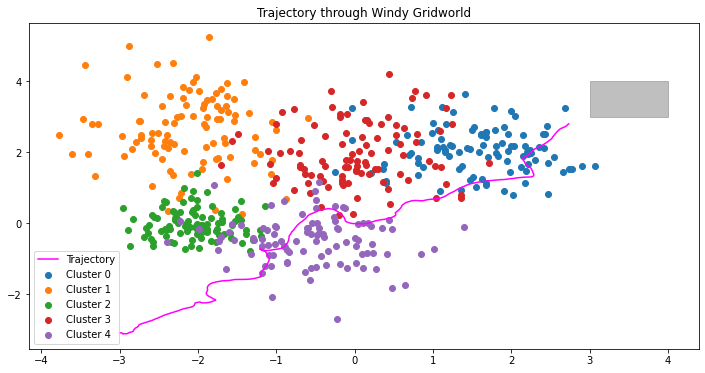

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 4 4 2 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3
 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [396]:
fig, ax2 = plt.subplots(figsize=(12,6))

index = np.random.randint(0,len(X_window))
history = np.array(X_window[index])
concept_history = concepts[index]
predicted_concepts = np.argmax(model1.predict(history), axis=1)

errors = len(np.where((concept_history - predicted_concepts)>0)[0])
print(f"Number of misclassified concepts: {errors}")


# print(f"Concepts visited: {concepts[index]}")
print(f"Reward: {rewards[index]}")
plt.plot(history[:, 0], history[:, 1], color="magenta", label="Trajectory")
rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()


print(concept_history)
print(predicted_concepts)

## $f(c|s,a)$

In [397]:
X_train, X_test, y_train, y_test = generate_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model2 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 3)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1544 - categorical_accuracy: 0.9343 - val_loss: 0.1406 - val_categorical_accuracy: 0.9383
Epoch 2/10
8051/8051 [==============================] - 9s 1ms/step - loss: 0.1401 - categorical_accuracy: 0.9392 - val_loss: 0.1364 - val_categorical_accuracy: 0.9410
Epoch 3/10
8051/8051 [==============================] - 8s 1ms/step - loss: 0.1391 - categorical_accuracy: 0.9390 - val_loss: 0.1329 - val_categorical_accuracy: 0.9416
Epoch 4/10
8051/8051 [==============================] - 8s 1ms/step - loss: 0.1374 - categorical_accuracy: 0.9398 - val_loss: 0.1346 - val_categorical_accuracy: 0.9413
Epoch 5/10
8051/8051 [==============================] - 8s 1ms/step - loss: 0.1369 - categorical_accuracy: 0.9396 - val_loss: 0.1323 - val_categorical_accuracy: 0.9423
Epoch 6/10
8051/8051 [==============================] - 8s 1ms/step - loss: 0.1361 - categorical_accuracy: 0.9402 - val_loss: 0.1330 - v

## $f(c|s,s')$

In [402]:
X_train, X_test, y_train, y_test = generate_states_next_states_dataset()
print(X_train.shape)
print(y_train.shape)
model3 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 4)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 14s 2ms/step - loss: 0.1476 - categorical_accuracy: 0.9373 - val_loss: 0.1353 - val_categorical_accuracy: 0.9405
Epoch 2/10
8051/8051 [==============================] - 13s 2ms/step - loss: 0.1337 - categorical_accuracy: 0.9412 - val_loss: 0.1312 - val_categorical_accuracy: 0.9422
Epoch 3/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1314 - categorical_accuracy: 0.9423 - val_loss: 0.1293 - val_categorical_accuracy: 0.9434
Epoch 4/10
8051/8051 [==============================] - 12s 1ms/step - loss: 0.1298 - categorical_accuracy: 0.9427 - val_loss: 0.1319 - val_categorical_accuracy: 0.9428
Epoch 5/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.1279 - categorical_accuracy: 0.9440 - val_loss: 0.1303 - val_categorical_accuracy: 0.9436
Epoch 6/10
8051/8051 [==============================] - 10s 1ms/step - loss: 0.1262 - categorical_accuracy: 0.9445 - val_loss: 0.12

In [399]:
score = model3.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 898us/step - loss: 0.1008 - categorical_accuracy: 0.9561
Test loss: 0.10082008689641953 
Test accuracy: 0.9561371803283691


## $f(c|s,a,s')$

In [405]:
X_train, X_test, y_train, y_test = generate_states_next_states_actions_dataset()
print(X_train.shape)
print(y_train.shape)
model4 = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history4 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)

(322004, 5)
(322004, 5)
Epoch 1/10
8051/8051 [==============================] - 12s 1ms/step - loss: 0.1501 - categorical_accuracy: 0.9358 - val_loss: 0.1292 - val_categorical_accuracy: 0.9438
Epoch 2/10
8051/8051 [==============================] - 14s 2ms/step - loss: 0.1360 - categorical_accuracy: 0.9400 - val_loss: 0.1344 - val_categorical_accuracy: 0.9415
Epoch 3/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1340 - categorical_accuracy: 0.9410 - val_loss: 0.1389 - val_categorical_accuracy: 0.9400
Epoch 4/10
8051/8051 [==============================] - 11s 1ms/step - loss: 0.1323 - categorical_accuracy: 0.9418 - val_loss: 0.1287 - val_categorical_accuracy: 0.9444
Epoch 5/10
8051/8051 [==============================] - 13s 2ms/step - loss: 0.1308 - categorical_accuracy: 0.9425 - val_loss: 0.1298 - val_categorical_accuracy: 0.9431
Epoch 6/10
8051/8051 [==============================] - 16s 2ms/step - loss: 0.1299 - categorical_accuracy: 0.9426 - val_loss: 0.12

In [406]:
score = model4.evaluate(X_test, y_test)
print(f"Test loss: {score[0]} \nTest accuracy: {score[1]}")

2516/2516 [==============================] - 2s 881us/step - loss: 0.1215 - categorical_accuracy: 0.9475
Test loss: 0.12150180339813232 
Test accuracy: 0.9474540948867798
